- **Download dataset**

In [1]:
!gdown https://drive.google.com/file/d/1EUYiGqgu5InaSk7ZLeWIG64673tveElF/view?usp=drive_link --fuzzy
!unzip numpy_files.zip

Downloading...
From (original): https://drive.google.com/uc?id=1EUYiGqgu5InaSk7ZLeWIG64673tveElF
From (redirected): https://drive.google.com/uc?id=1EUYiGqgu5InaSk7ZLeWIG64673tveElF&confirm=t&uuid=5e5b29cd-ffb9-47be-86bc-3e745312fd9e
To: /content/numpy_files.zip
100% 183M/183M [00:03<00:00, 57.9MB/s]
Archive:  numpy_files.zip
   creating: numpy_files/
   creating: numpy_files/split_data/
  inflating: numpy_files/split_data/split_images.npz  
  inflating: numpy_files/split_data/split_image_name.npz  
  inflating: numpy_files/split_data/split_gray_feature.npz  
  inflating: numpy_files/split_data/split_canny_feature.npz  
  inflating: numpy_files/split_data/split_local_binary_pattern_feature.npz  
  inflating: numpy_files/split_data/split_cardboard_class.npz  
  inflating: numpy_files/split_data/split_bbox.npz  
  inflating: numpy_files/split_data/split_segmentation.npz  
  inflating: numpy_files/split_data/split_segmentation_category.npz  
 extracting: numpy_files/image_name.npz  
  infl

In [2]:
import cv2
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt

## Load dataset

In [3]:
images = np.load("numpy_files/split_data/split_images.npz")
image_name = np.load("numpy_files/split_data/split_image_name.npz", allow_pickle=True)
cardboard_class = np.load("numpy_files/split_data/split_cardboard_class.npz")
bbox = np.load("numpy_files/split_data/split_bbox.npz")
segmentation = np.load("numpy_files/split_data/split_segmentation.npz")
segmentation_category = np.load("numpy_files/split_data/split_segmentation_category.npz")

- Ubah shape data `images` (n, 1, 300, 400, 3) -> (n, 300, 400, 3)
- Ubah shape data `cardboard_class` (n, 1, 2) -> (n, 2)
- Ubah shape data `segmentation` (n, 5, 300, 400) -> (n, 300, 400, 5)
- Sekedar mengingatkan 1 data `segmentation` memiliki 5 channel, diantaranya:
  - background kardus
  - bagian kardus yang tidak ada kerusakan
  - kerusakan bertipe *hilang*
  - kerusakan bertipe *penyok*
  - kerusakan bertipe *robek*
- Gabungkan setiap data tipe kerusakan jadi 1, dan jadikan sebagai data utamanya. Jadi 1 citra akan memiliki data `segmentation` dengan shape (300, 400, 1)

In [4]:
# buat variabel temporary
temp_images = {}
temp_cardboard_class = {}
temp_segmentation = {}

# buat iterasi setiap subset (train, test, val)
for i in images.keys():

    # hilangkan dimensi pada axis=1 pada citra
    temp_images[i] = np.squeeze(images[i], axis=1)

    # reshape data cardboard_class menjadi (n, 2)
    temp_cardboard_class[i] = cardboard_class[i].reshape(-1, 2)

    # ubah posisi channel pada segmentasi menjadi posisi terakhir
    temp_segmentation[i] = np.transpose(segmentation[i], [0, 2, 3, 1])

    # buat masking full hitam
    temp_segmentation[i][..., 1] = np.zeros(temp_segmentation[i].shape[:-1])

    # iterasi setiap index pada data segmentasi yang berisi tipe kerusakan
    for j in [2, 3, 4]:

        # gabungkan jadi 1 setiap tipe kerusakan pada masking full hitam tadi dengan logical or
        temp_segmentation[i][..., 1] = np.logical_or(
            temp_segmentation[i][..., 1], temp_segmentation[i][..., j]
        )

    # jadikan gabungan tadi menjadi data utama
    temp_segmentation[i] = temp_segmentation[i][..., [1]]

# kembalikan ke variabel asalnya
images = temp_images
cardboard_class = temp_cardboard_class
segmentation = temp_segmentation

In [5]:
# hapus variabel temporary dari memori
del temp_images
del temp_cardboard_class
del temp_segmentation

In [6]:
# cek shape data segmentasi
segmentation["test"].shape

(37, 300, 400, 1)

## Pembuatan Model

In [7]:
pre_trained = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(300, 400, 3))
pre_trained.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [42]:
class_output = tf.keras.layers.Flatten()(pre_trained.output)
class_output = tf.keras.layers.Dropout(0.1)(class_output)
class_output = tf.keras.layers.Dense(64, activation='relu')(class_output)
class_output = tf.keras.layers.Dense(2, activation="softmax", name="class_output")(class_output)

In [43]:
model = tf.keras.Model(
    inputs=pre_trained.input,
    outputs={
        "class_output": class_output,
    },
)

In [44]:
# tampilkan ringkasan model
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 300, 400, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 300, 400, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 300, 400, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 150, 200, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 150, 200, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 150, 200, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 75, 100, 128)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 75, 100, 256)        │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 75, 100, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 75, 100, 256)        │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 37, 50, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 37, 50, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 37, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 37, 50, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 18, 25, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 18, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 18, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 18, 25, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 9, 12, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 18,253,826 (69.63 MB)

 Trainable params: 3,539,138 (13.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

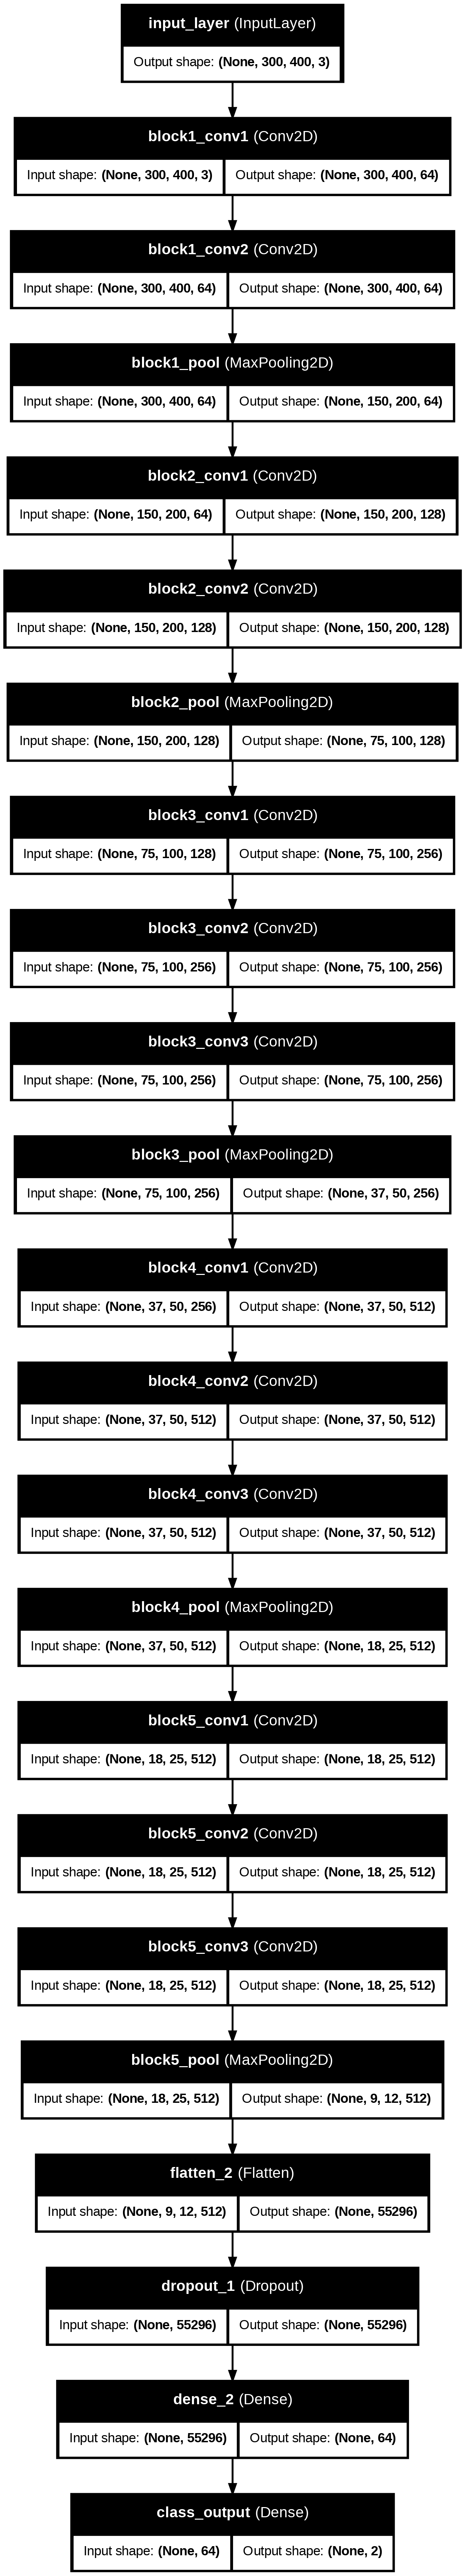

In [45]:
# tampilkan plot model
tf.keras.utils.plot_model(model,show_shapes=True,
    show_layer_names=True,
)

## Hyperparameter

In [46]:
EPOCHS = 15
BATCH_SIZE = 4
LR = 1e-5

## Proses Training Model

In [47]:
model.compile(
    # set loss untuk masing masing output
    loss={
        "class_output": "categorical_crossentropy",
    },
    metrics ={
        "class_output": ["accuracy"],
        }
    ,
    # pakai optimizer adam dengan learning rate pada hyperparameter
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR)
)

In [48]:
# train model
history = model.fit(
    images['train'],
    {
        "class_output": cardboard_class['train'],
    },
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(images['val'], {
        "class_output": cardboard_class['val'],
    })
)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.5491 - loss: 0.7671 - val_accuracy: 0.6486 - val_loss: 0.6264
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.6874 - loss: 0.5650 - val_accuracy: 0.7027 - val_loss: 0.4535
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8619 - loss: 0.3896 - val_accuracy: 0.8108 - val_loss: 0.3888
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8840 - loss: 0.3313 - val_accuracy: 0.8108 - val_loss: 0.3497
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.9306 - loss: 0.2598 - val_accuracy: 0.8649 - val_loss: 0.3268
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9446 - loss: 0.2376 - val_accuracy: 0.8649 - val_loss: 0.3168
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.9584 - loss: 0.2010 - val_accuracy: 0.7838 - val_loss: 0.3491
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9492 - loss: 0.1965 - val_accuracy: 0.8919

## Evaluasi Model

In [49]:
# tampilkan data histori train yang tersimpan
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [50]:
# ambil metrics loss dan akurasi train dan validasi untuk masing masing output
class_output_metrics = {'accuracy':history.history['accuracy'], 'loss':history.history['loss']}
val_class_output_metrics = {'accuracy':history.history['val_accuracy'], 'loss':history.history['val_loss']}

### Plot hasil histori train dan validasi

Text(0.5, 1.0, 'Class Cardboard Loss')

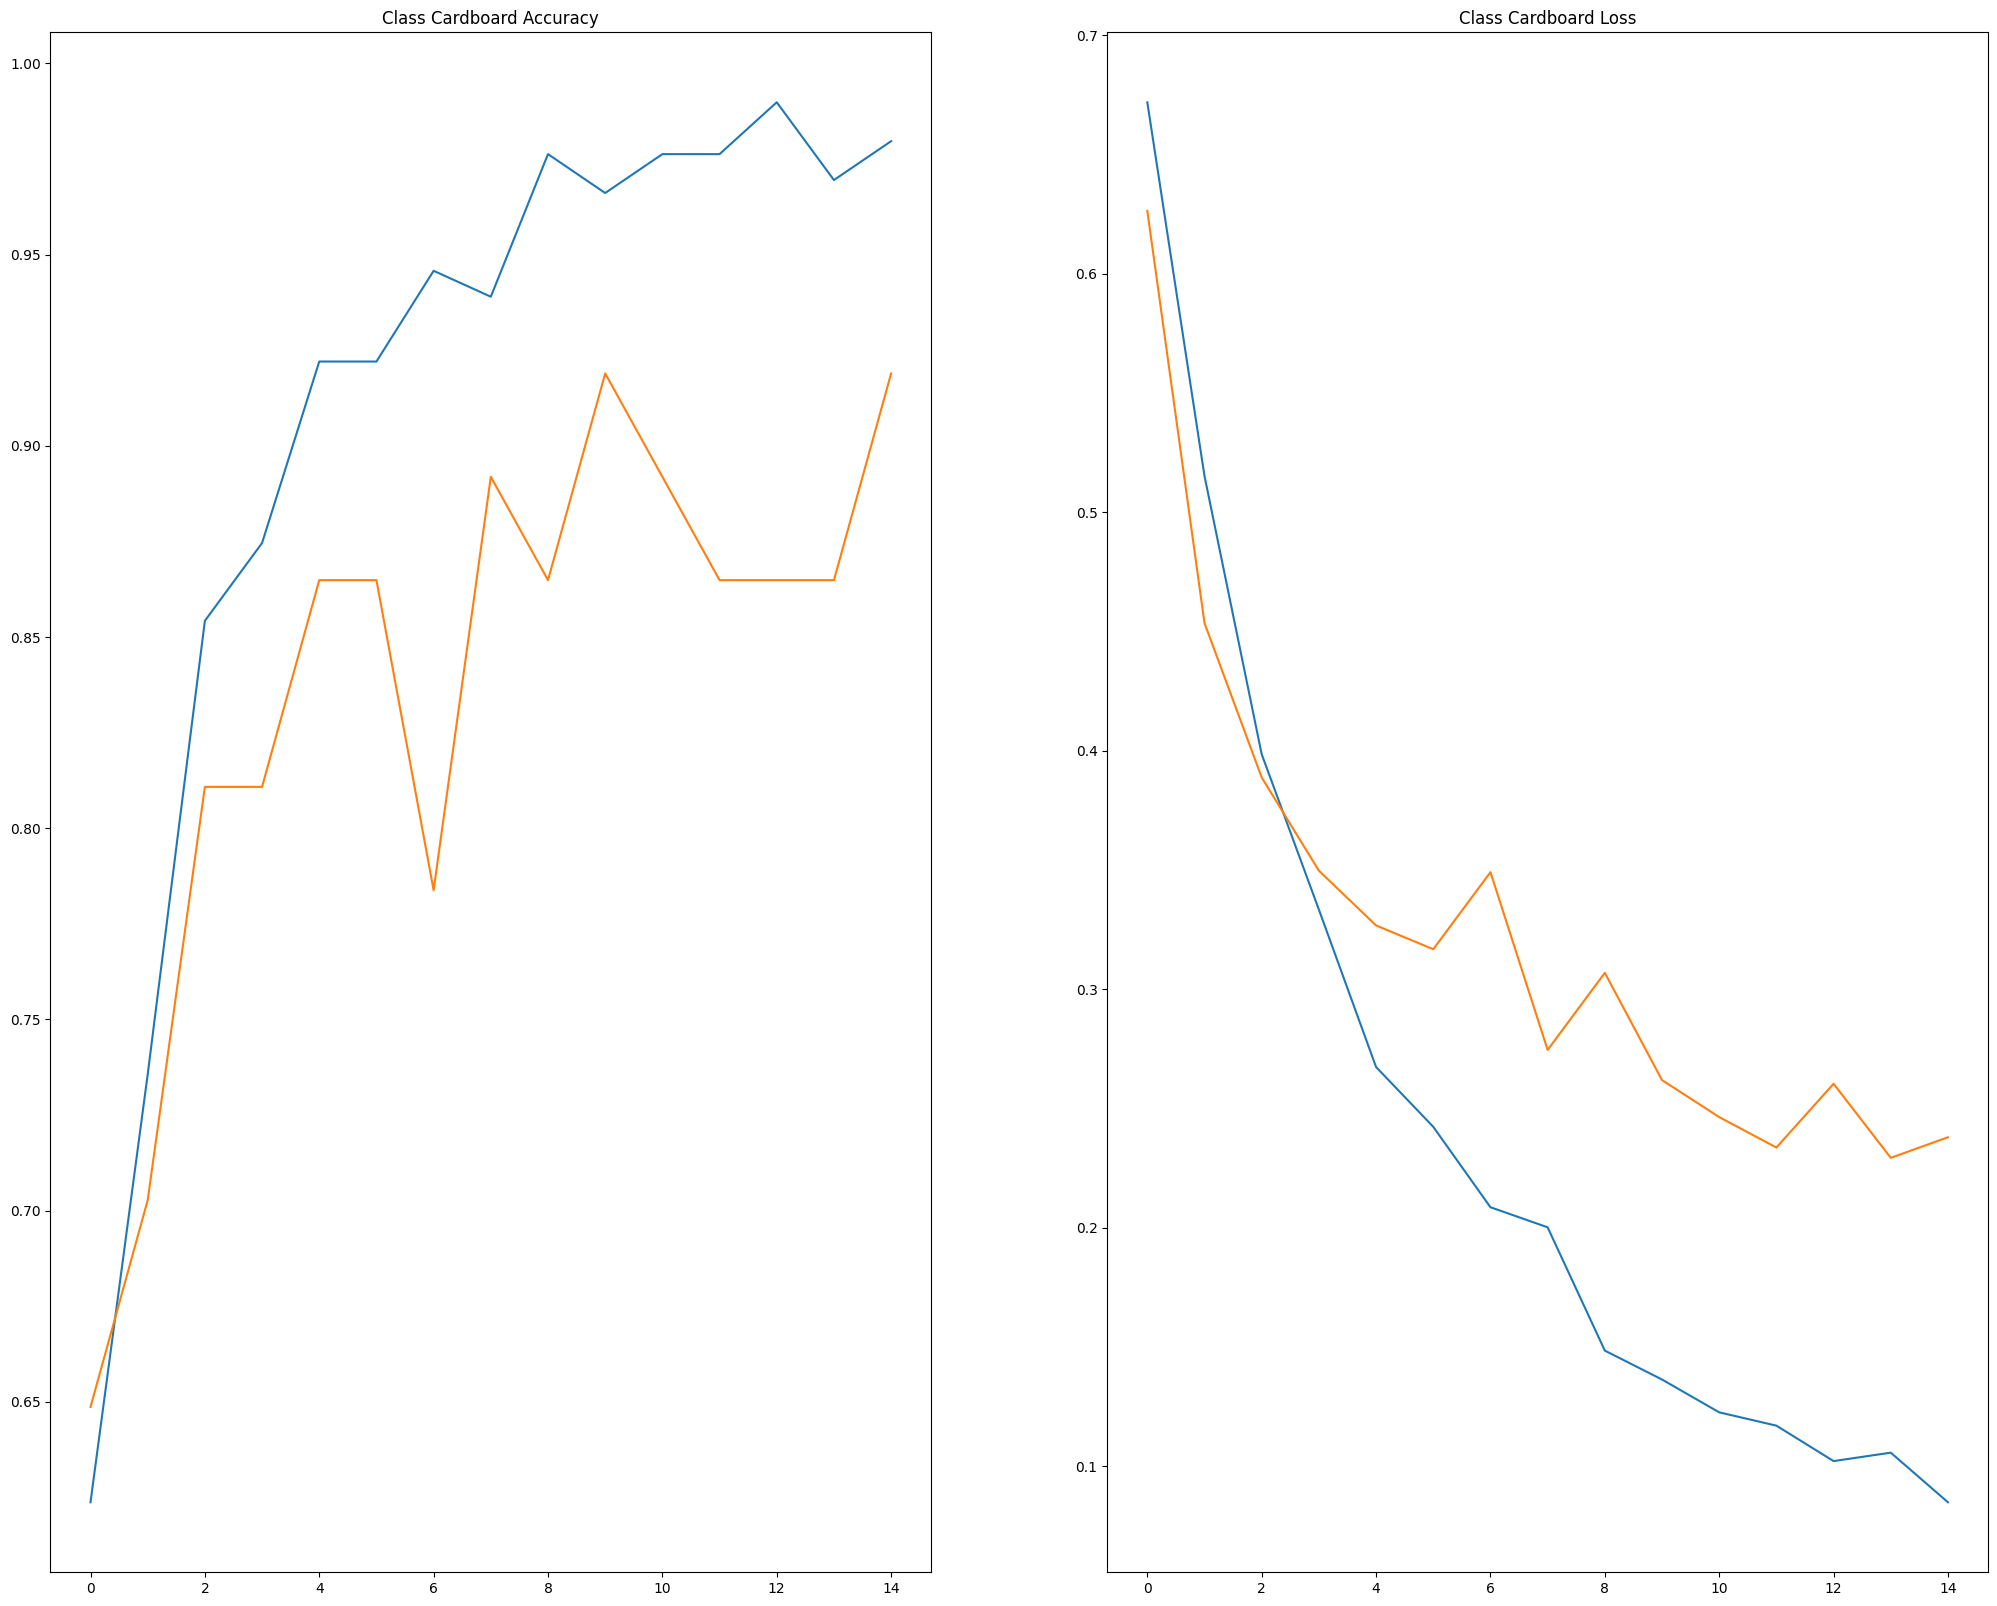

In [51]:
fig,ax = plt.subplots(1,2,figsize=(25,20))

ax[0].plot(class_output_metrics['accuracy'])
ax[0].plot(val_class_output_metrics['accuracy'])
ax[0].set_title('Class Cardboard Accuracy')

ax[1].plot(class_output_metrics["loss"])
ax[1].plot(val_class_output_metrics["loss"])
ax[1].set_title('Class Cardboard Loss')

### Classification Report dan Confussion Matrix

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(cardboard_class['test'], axis=1)
y_pred = np.argmax(model.predict(images['test'], batch_size=BATCH_SIZE)['class_output'], axis=1)

print(classification_report(y_true, y_pred, target_names=['normal', 'defect']))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
              precision    recall  f1-score   support

      normal       0.94      0.94      0.94        18
      defect       0.95      0.95      0.95        19

    accuracy                           0.95        37
   macro avg       0.95      0.95      0.95        37
weighted avg       0.95      0.95      0.95        37



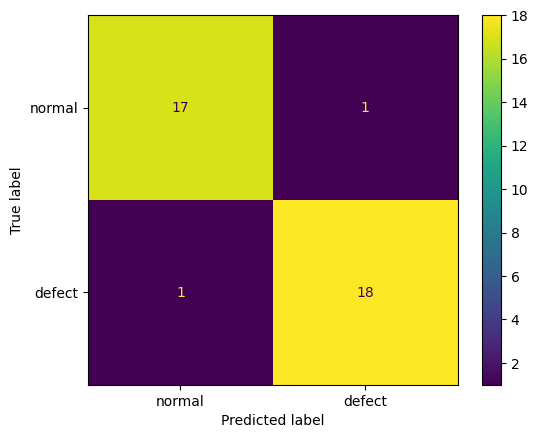

In [53]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['normal', 'defect']).plot()

In [62]:
# save model ke drive (KHUSUS GOOGLE COLAB)
from google.colab import drive
drive.mount("drive")
model.save("/content/drive/MyDrive/object_detection_cardboard/vgg_model.h5")

Mounted at drive
